In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import box, Polygon
from shapely import affinity
import rioxarray
from sklearn.cluster import DBSCAN
import os
from rasterio.features import shapes

from src.utils import read_neon_trees

root = Path.cwd()

In [41]:
class NeonSite:
    def __init__(self,site,epsg):
        self.site = site
        self.epsg = epsg
        self.epsg_int = int(self.epsg.split(':')[1])
        self.base_dir = 'c:/Users/roseh/OneDrive - Hunter - CUNY/Documents/beech_tree'
        self.all_trees = self.read_neon_trees()
        self.filtered_trees = gpd.GeoDataFrame()

        self.sentinel_indices = xr.open_dataarray(self.base_dir / 'sentinel_data' / f'2019_{self.site}_indices.nc')
        sent_i = self.sentinel.rio.write_crs(self.epsg_int).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

        self.sentinel_bands = xr.open_dataarray(self.base_dir / 'sentinel_data' / f'2019_{self.site}.nc')
        sent_b = self.sentinel.rio.write_crs(self.epsg_int).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

    def read_neon_trees(self):
    
        trees_df = pd.read_csv(os.path.join(self.base_dir,'output',self.site, f'neon_trees_{self.site}.csv'))
        if self.site == 'BART':
            trees_df.taxonID = trees_df.taxonID.replace(to_replace='BEPA',value='BEPAP')
        trees_df.taxonID.value_counts()
        geometry = gpd.points_from_xy(trees_df.easting_tree, trees_df.northing_tree, crs=self.epsg)
        trees_df['geometry'] = geometry
        trees_gdf = gpd.GeoDataFrame(trees_df,geometry='geometry',crs=self.epsg)
        # add crown buffer
        trees_gdf['crown_buffer'] = trees_gdf.apply(lambda row: row['geometry'].buffer(row['ninetyCrownDiameter']/2) if not np.isnan(row['ninetyCrownDiameter']) else np.nan, axis=1)

        return trees_gdf
    
    def save_all_trees(self):
        trees_buffer = self.all_trees.drop('geometry',axis=1).set_geometry('crown_buffer',crs=self.epsg_int)
        trees = self.all_trees.drop('crown_buffer',axis=1)

        trees.to_file(os.path.join(self.base_dir,'output',self.site,f'all_trees_{self.site}.gpkg'))
        trees_buffer.to_file(os.path.join(self.base_dir,'output',self.site,f'all_trees_crowns_{self.site}.gpkg'))
    
    def filter_trees(self):
        #Filter for trees within 1.5 std of median difference between survey observed tree height and chm observed tree height
        chm_dif_med = self.all_trees.chm_dif.median()
        chm_dif_std = self.all_trees.chm_dif.std()
        threshold1 = chm_dif_med-chm_dif_std*1.5
        threshold2 = chm_dif_med + chm_dif_std*1.5

        filtered_trees = self.all_trees.loc[(self.all_trees.chm_dif > threshold1) & (self.all_trees.chm_dif < threshold2)].reset_index(drop=True)
        if len(filtered_trees) == 0:
            print('no trees here')
            
        #Calculate distance matrix between all trees
        dist_matrix = filtered_trees.geometry.apply(lambda g: filtered_trees.distance(g)).to_numpy()
        #Grab upper triangle of distance matrix since dist mat is symmetrical
        upper_tri = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
        #Find a distance threshold for trees that might be too close together
        thresh = np.median(upper_tri) - upper_tri.std()*1.5
        #Get index pairs where trees are suspiciously close
        #Sort + Set to remove redundant pairs i.e. (12, 14) and (14, 12) and identical pairs
        sus_indexes = set(tuple(sorted(x)) for x in np.argwhere(dist_matrix<thresh) if x[0] != x[1])
        to_drop = list()
        for sus in sus_indexes:

            height_0 = filtered_trees.loc[sus[0]]['height']
            height_1 = filtered_trees.loc[sus[1]]['height']
            #When two trees are very close, pick the higher one as observed from ground survey (not chm for consistency with scholl), drop the shorter one
            to_add = sus[0] if height_1>=height_0 else sus[1]
            to_drop.append(to_add)

        to_drop = set(to_drop)
        filtered_trees = filtered_trees.drop(to_drop).reset_index(drop=True)
        self.filtered_trees = filtered_trees
        return filtered_trees
    
    def save_filtered_trees(self):
        trees_buffer = self.filtered_trees.drop('geometry',axis=1).set_geometry('crown_buffer',crs=self.epsg_int)
        trees = self.filtered_trees.drop('crown_buffer',axis=1)

        trees.to_file(os.path.join(self.base_dir,'output',self.site,f'filtered_trees_{self.site}.gpkg'))
        trees_buffer.to_file(os.path.join(self.base_dir,'output',self.site,f'filtered_trees_crowns_{self.site}.gpkg'))

    

    

In [ ]:
bart = NeonSite('BART',"EPSG:26919")

In [46]:
ft = bart.filter_trees()

In [49]:
site = 'BART'
epsg = "EPSG:26919"
epsg2 = 26919

trees = read_neon_trees(root,site,epsg=epsg)

def add_crown_buffer(gdf):
    gdf['crown_buffer'] = gdf.apply(lambda row: row['geometry'].buffer(row['ninetyCrownDiameter']/2) if not np.isnan(row['ninetyCrownDiameter']) else row['ninetyCrownDiameter'].mean(), axis=1)
    return gdf

trees = add_crown_buffer(trees)

### Vectorize Sentinel data

In [2]:
t = gpd.read_file(root / 'output' / 'BART' / 'filtered_trees_BART.gpkg')

In [15]:
epsg2 = 26919
b = xr.open_dataarray(root / 'sentinel_data' / '2019_bart_indices.nc')
b = b.rio.write_crs(epsg2).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

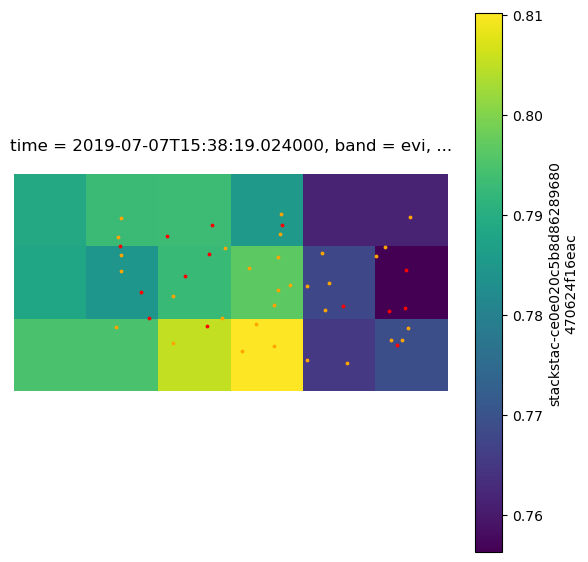

In [23]:
# buffer arbitrary cluster
buffer = t.iloc[1273:1274,].buffer(50)

points_idx = buffer.sindex.query(t.geometry, predicate="intersects")[0]
clipped_trees = t.iloc[points_idx]
bx = box(*clipped_trees.total_bounds)

bigger_box = affinity.scale(bx, xfact=1.5, yfact=1.5)

clip_df = gpd.GeoDataFrame(
    geometry=[bigger_box],
    crs="EPSG:26919"
)

clipped_raster = b.isel(band=1,time=12).rio.clip(clip_df.geometry.values, crs=26919, drop=True, invert=False)
clipped_beech = clipped_trees.loc[clipped_trees['taxonID']=='FAGR']
clipped_nonbeech = clipped_trees.loc[clipped_trees['taxonID']!='FAGR']

fig, ax = plt.subplots(ncols=1, figsize=(7, 7))

clipped_raster.plot.imshow(ax=ax)

clipped_beech.plot(ax=ax,color='orange',markersize=3)
clipped_nonbeech.plot(ax=ax,color='red',markersize=3)
#clipped_trees['crown_buffer'].plot(ax=ax, edgecolor='pink',facecolor='none')


# plot crown buffers
#['crown_buffer'].plot(ax=ax, edgecolor='yellow',facecolor='none')
# f2_beech = f2.loc[f2['taxonID']=='FAGR']
# f2_nonbeech = f2.loc[f2['taxonID']!='FAGR']


ax.set_axis_off()

In [104]:
# create vector grid from raster cells
polygons = shapes(clipped_raster.values, transform=clipped_raster.rio.transform())
# Create a list of dictionaries for each polygon
geometry = []
ids = []
i = 1
for polygon, value in polygons:
        geometry.append(polygon)
        ids.append(i)
        i += 1   

# Create a GeoDataFrame from the features
gdf_dict = {'geometry':[Polygon(x['coordinates'][0]) for x in geometry],'cell_id':list(range(1,len(geometry)+1))}

gdf = gpd.GeoDataFrame(gdf_dict, crs=clipped_raster.rio.crs)

In [105]:
# join beech points to polygons
j = gpd.sjoin(gdf, clipped_beech, predicate='contains') 


In [138]:
beech_per_plot = j.groupby('cell_id').plotID.agg('count') # number of beech per plot

In [144]:
beech_per_plot = beech_per_plot.to_frame().reset_index()

In [149]:
gdf.merge(beech_per_plot,on='cell_id',how='outer')  # need to rename plotID to number of beech

,cell_id,index,geometry,plotID
0,1,0,"POLYGON ((317095 4881125, 317095 4881115, 3171...",NaN
1,2,1,"POLYGON ((317105 4881125, 317105 4881115, 3171...",2.0
2,3,2,"POLYGON ((317115 4881125, 317115 4881115, 3171...",NaN
3,4,3,"POLYGON ((317125 4881125, 317125 4881115, 3171...",2.0
4,5,4,"POLYGON ((317135 4881125, 317135 4881115, 3171...",NaN
5,6,5,"POLYGON ((317145 4881125, 317145 4881115, 3171...",1.0
6,7,6,"POLYGON ((317095 4881115, 317095 4881105, 3171...",NaN
7,8,7,"POLYGON ((317105 4881115, 317105 4881105, 3171...",2.0
8,9,8,"POLYGON ((317115 4881115, 317115 4881105, 3171...",3.0
9,10,9,"POLYGON ((317125 4881115, 317125 4881105, 3171...",5.0


In [3]:
def filter_trees(gdf):
        #Filter for trees within 1.5 std of median difference between survey observed tree height and chm observed tree height
        chm_dif_med = gdf.chm_dif.median()
        chm_dif_std = gdf.chm_dif.std()
        threshold1 = chm_dif_med-chm_dif_std*1.5
        threshold2 = chm_dif_med + chm_dif_std*1.5

        filtered_trees = gdf.loc[(gdf.chm_dif > threshold1) & (gdf.chm_dif < threshold2)].reset_index(drop=True)
        if len(filtered_trees) == 0:
            return filtered_trees
        #Calculate distance matrix between all trees
        dist_matrix = filtered_trees.geometry.apply(lambda g: filtered_trees.distance(g)).to_numpy()
        #Grab upper triangle of distance matrix since dist mat is symmetrical
        upper_tri = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
        #Find a distance threshold for trees that might be too close together
        thresh = np.median(upper_tri) - upper_tri.std()*1.5
        #Get index pairs where trees are suspiciously close
        #Sort + Set to remove redundant pairs i.e. (12, 14) and (14, 12) and identical pairs
        sus_indexes = set(tuple(sorted(x)) for x in np.argwhere(dist_matrix<thresh) if x[0] != x[1])
        to_drop = list()
        for sus in sus_indexes:

            height_0 = filtered_trees.loc[sus[0]]['height']
            height_1 = filtered_trees.loc[sus[1]]['height']
            #When two trees are very close, pick the higher one as observed from ground survey (not chm for consistency with scholl), drop the shorter one
            to_add = sus[0] if height_1>=height_0 else sus[1]
            to_drop.append(to_add)

        to_drop = set(to_drop)
        filtered_trees = filtered_trees.drop(to_drop).reset_index(drop=True)
        
        return filtered_trees

In [53]:
trees_buffer = trees.drop('geometry',axis=1).set_geometry('crown_buffer',crs=epsg2)
trees = trees.drop('crown_buffer',axis=1)

trees.to_file(f'output/{site}/all_trees_{site}.gpkg')
trees_buffer.to_file(f'output/{site}/all_trees_crowns{site}.gpkg')

In [51]:
f2 = filter_trees(trees)
f2.shape

(1588, 18)

In [31]:
f2_buffer = f2.drop('geometry',axis=1).set_geometry('crown_buffer',crs=epsg2)

In [32]:
f2 = f2.drop('crown_buffer',axis=1)

In [33]:
f2.to_file(f'output/{site}/filtered_trees_{site}.gpkg')
f2_buffer.to_file(f'output/{site}/filtered_trees_crowns{site}.gpkg')

In [88]:
# pixels selected manually based on sentinel data
q = pd.concat([gpd.read_file(f) for f in os.scandir(root/'temp')])

In [90]:
q.loc[q.taxonID=='FAGR'].shape

(18, 17)

In [91]:
q.loc[q.taxonID!='FAGR'].shape

(33, 17)